***Using ARIMA model to predict food_retail capital in Australia.***

In [23]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy

In [28]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/australian_capital_retail.csv')

**Task 1: Aggregate the yearly sum of "food retailing" and visualize it over time.**



Text(0.5, 1.0, 'Yearly Sum of Food Retailing')

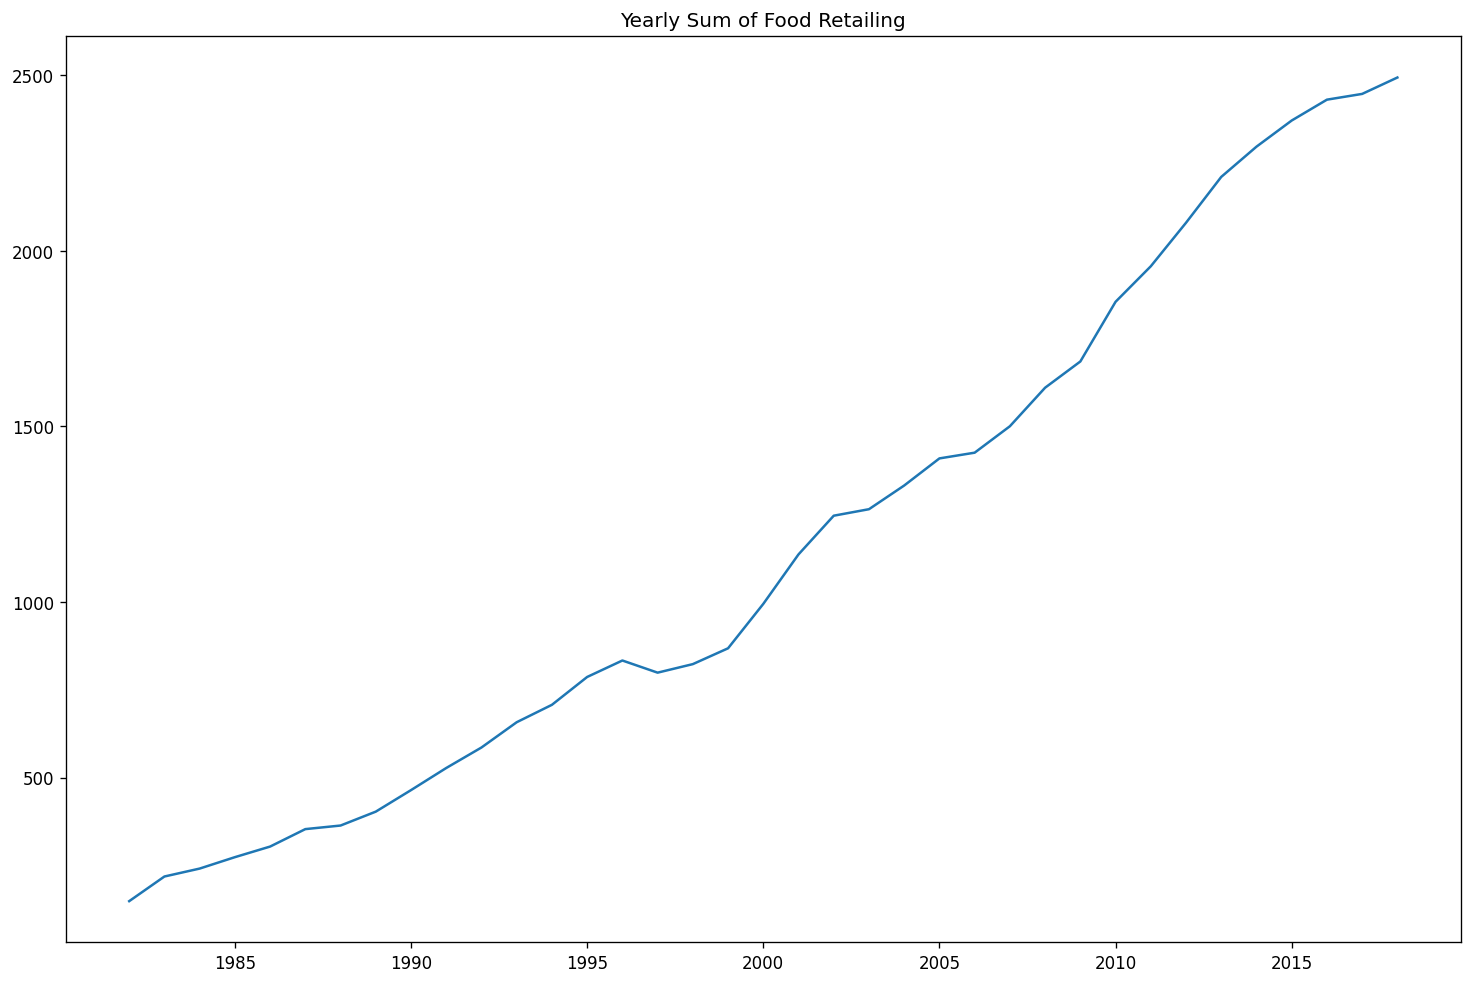

In [29]:
df['year']=pd.to_datetime(df.month).dt.year
#df.head()
fr = df.groupby('year')['food_retailing'].sum()
#fr.head()
plt.plot(fr.index, fr.values)
plt.title('Yearly Sum of Food Retailing')

**Task 2: Use the Augmented Dickey–Fuller Test at alpha=0.05 to find out if this timeseries is stationary. If it is not, use the ARIMA framework to locate a proper order of differencing (d) to reach stationarity. Report the Augmented Dickey–Fuller Test once you've succeded.**

In [30]:
frdf = pd.DataFrame(fr)
frdf.head()

,food_retailing
year,
1982,147.8
1983,218.0
1984,240.6
1985,273.1
1986,303.3


In [31]:
from statsmodels.tsa.stattools import adfuller

#serires=fr.values
series=frdf['food_retailing']
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.548309
p-value: 0.999064
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623


p-value of 99.91%. Therefore, can't reject the null hypothesis. Time-series highly likely not to be stationary.

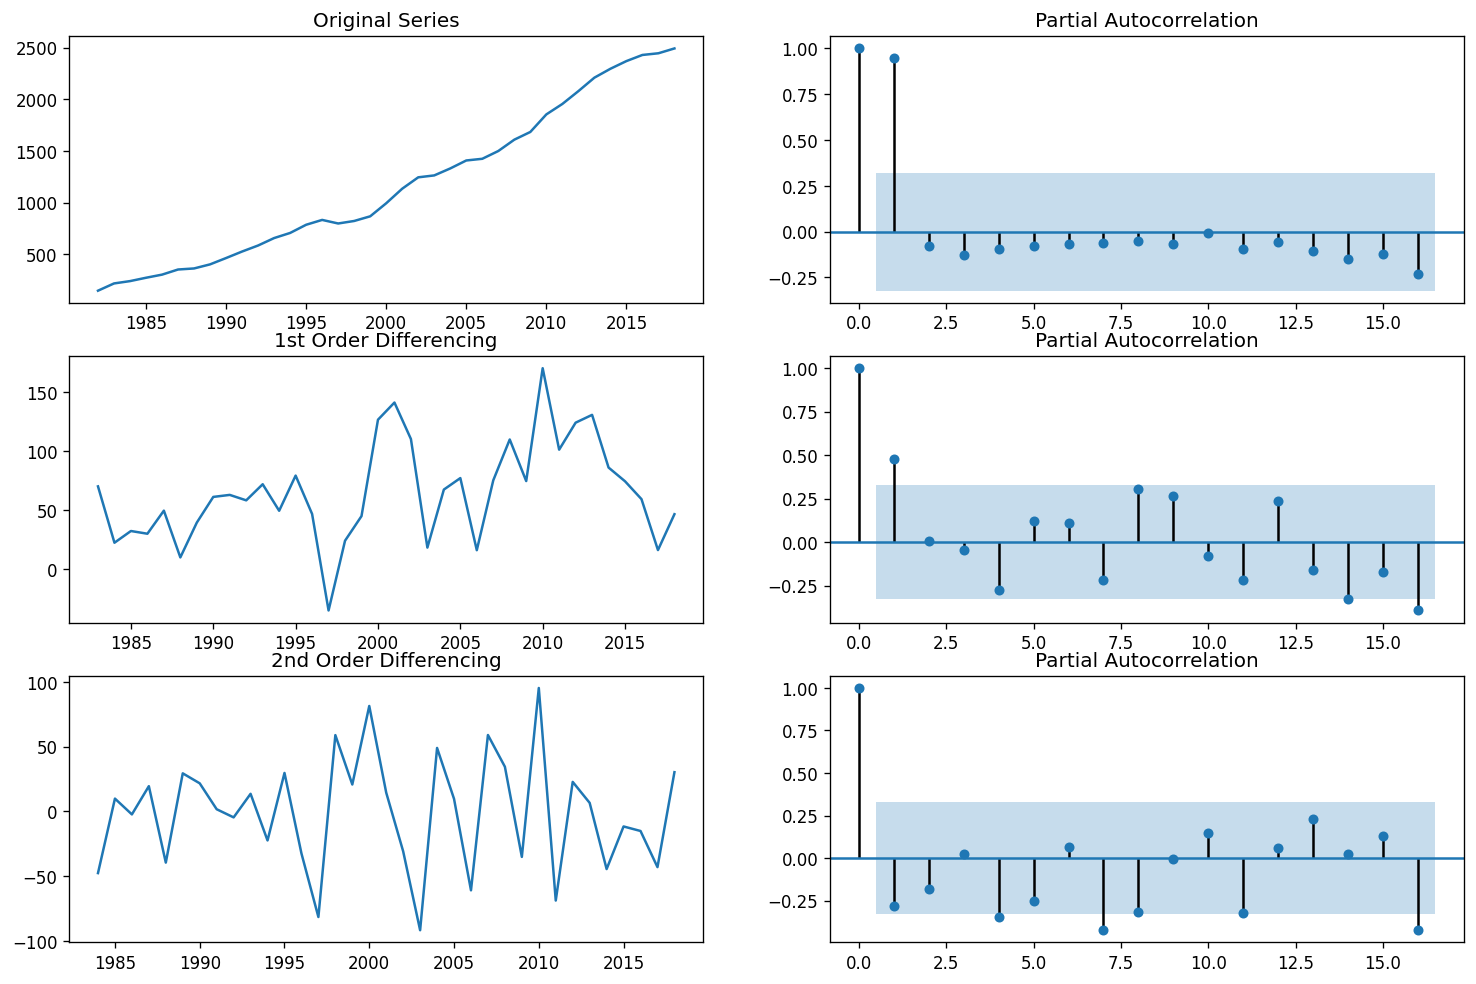

In [32]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(frdf.food_retailing); axes[0, 0].set_title('Original Series')
plot_pacf(frdf.food_retailing, ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')

# 1st Differencing
axes[1, 0].plot(frdf.food_retailing.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(frdf.food_retailing.diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation')

# 2nd Differencing
axes[2, 0].plot(frdf.food_retailing.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(frdf.food_retailing.diff().diff().dropna(), ax=axes[2, 1])
axes[2, 1].set_title('Partial Autocorrelation')

plt.show()

In [33]:
# raw
series=frdf['food_retailing']#.diff()
result = adfuller(series.dropna())
print('raw observations:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

# first order differencing
series=frdf['food_retailing'].diff()
result = adfuller(series.dropna())
print('\n1st order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

# second order differencing
series=frdf['food_retailing'].diff().diff()
result = adfuller(series.dropna())
print('\n2nd order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

raw observations:
  ADF Statistic: 2.548309
  p-value: 0.999064

1st order differencing:
  ADF Statistic: -3.444382
  p-value: 0.009536

2nd order differencing:
  ADF Statistic: -2.936616
  p-value: 0.041253


After first order differencing, ADF statistic and p-value are lower than critical value and significant value (0.05). Therefore, time series is now stationary. For forecasting, the number of differencing of ARIMA model will be 1(d).

**Task 3: Examine the PACF and ACF plots. What AR and/or MA orders would you choose if any?**

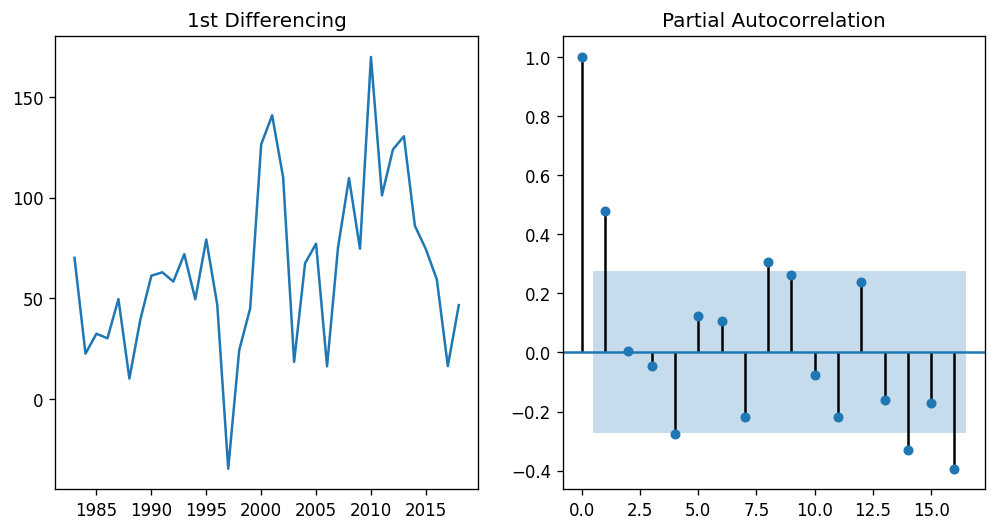

In [34]:
#AR
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(frdf.food_retailing.diff())
axes[0].set_title('1st Differencing')
# axes[1].set_ylim(0,1)
plot_pacf(frdf.food_retailing.diff().dropna(), ax=axes[1],alpha=0.1) #plot differences between consequtive observations

plt.show()


The PACF cuts off sharply at lag 1. Suggest AR term, Q=1.

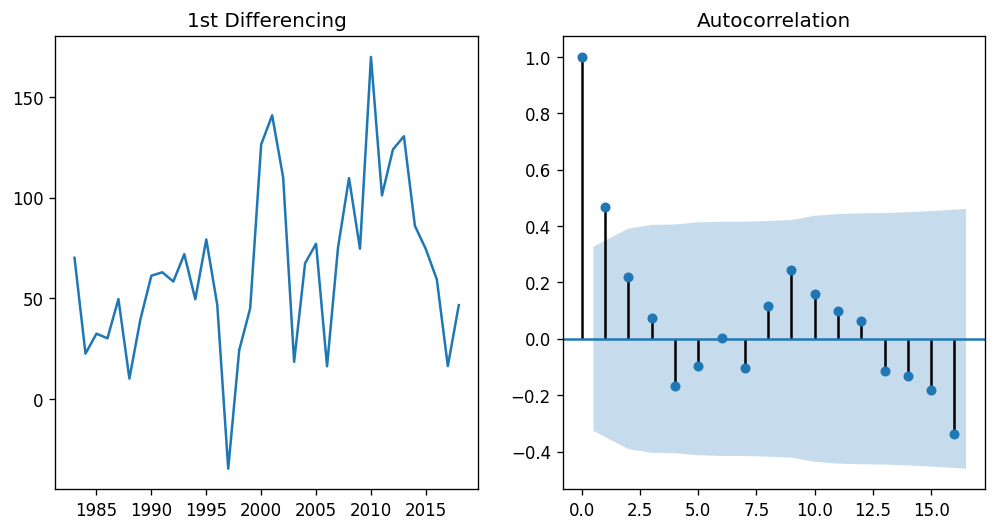

In [35]:
#MA
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(frdf.food_retailing.diff()); axes[0].set_title('1st Differencing')
plot_acf(frdf.food_retailing.diff().dropna(), ax=axes[1])

plt.show()

Along with significant cutoff in PACF plot, a noticeable/clear drop in the ACF plot after the first lag. Suggest MA term, P=1.


**Task 4: Train a model on the first 30 datapoints using an ARIMA(1,1,1) then predict on the last that 30-datapoint training set as well as the last 7 data points. Report and comment on residual diagnostics for both train and test periods, including MAE, RSME, PACF, ACF, a normality test, and a formal autocorrelation test (e.g., Ljung–Box test)**

                             ARIMA Model Results                              
Dep. Variable:       D.food_retailing   No. Observations:                   29
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -147.113
Method:                       css-mle   S.D. of innovations             38.506
Date:                Sat, 04 Jun 2022   AIC                            302.226
Time:                        10:04:53   BIC                            307.695
Sample:                             1   HQIC                           303.938
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     62.8623     10.767      5.838      0.000      41.759      83.966
ar.L1.D.food_retailing     0.1793      0.672      0.267      0.792      -1.138       1.497
ma.L

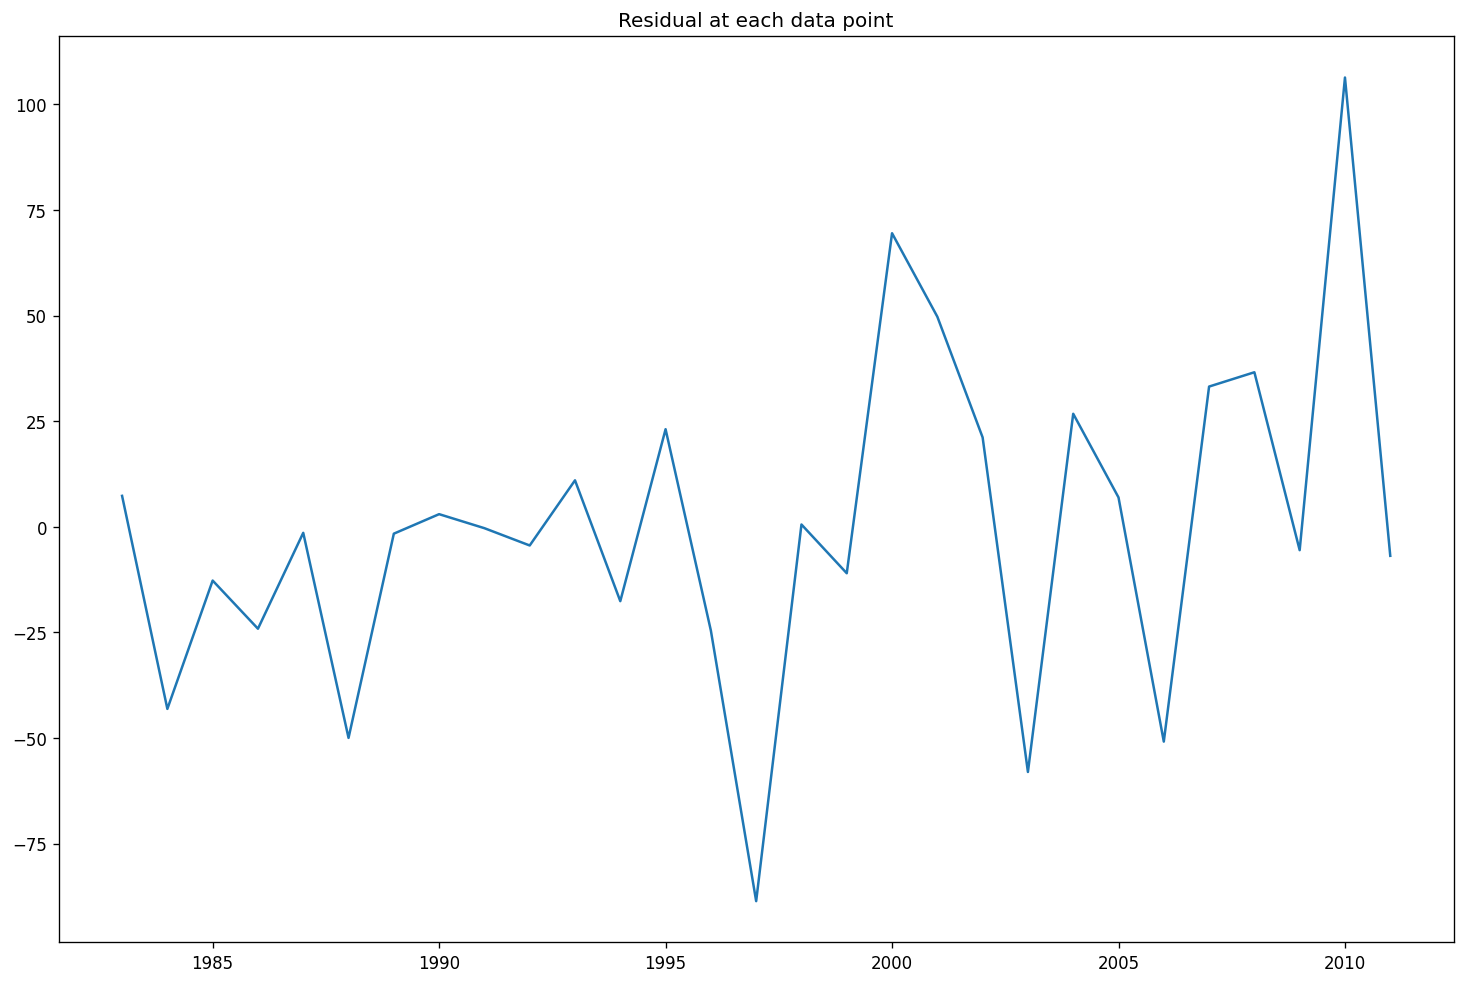

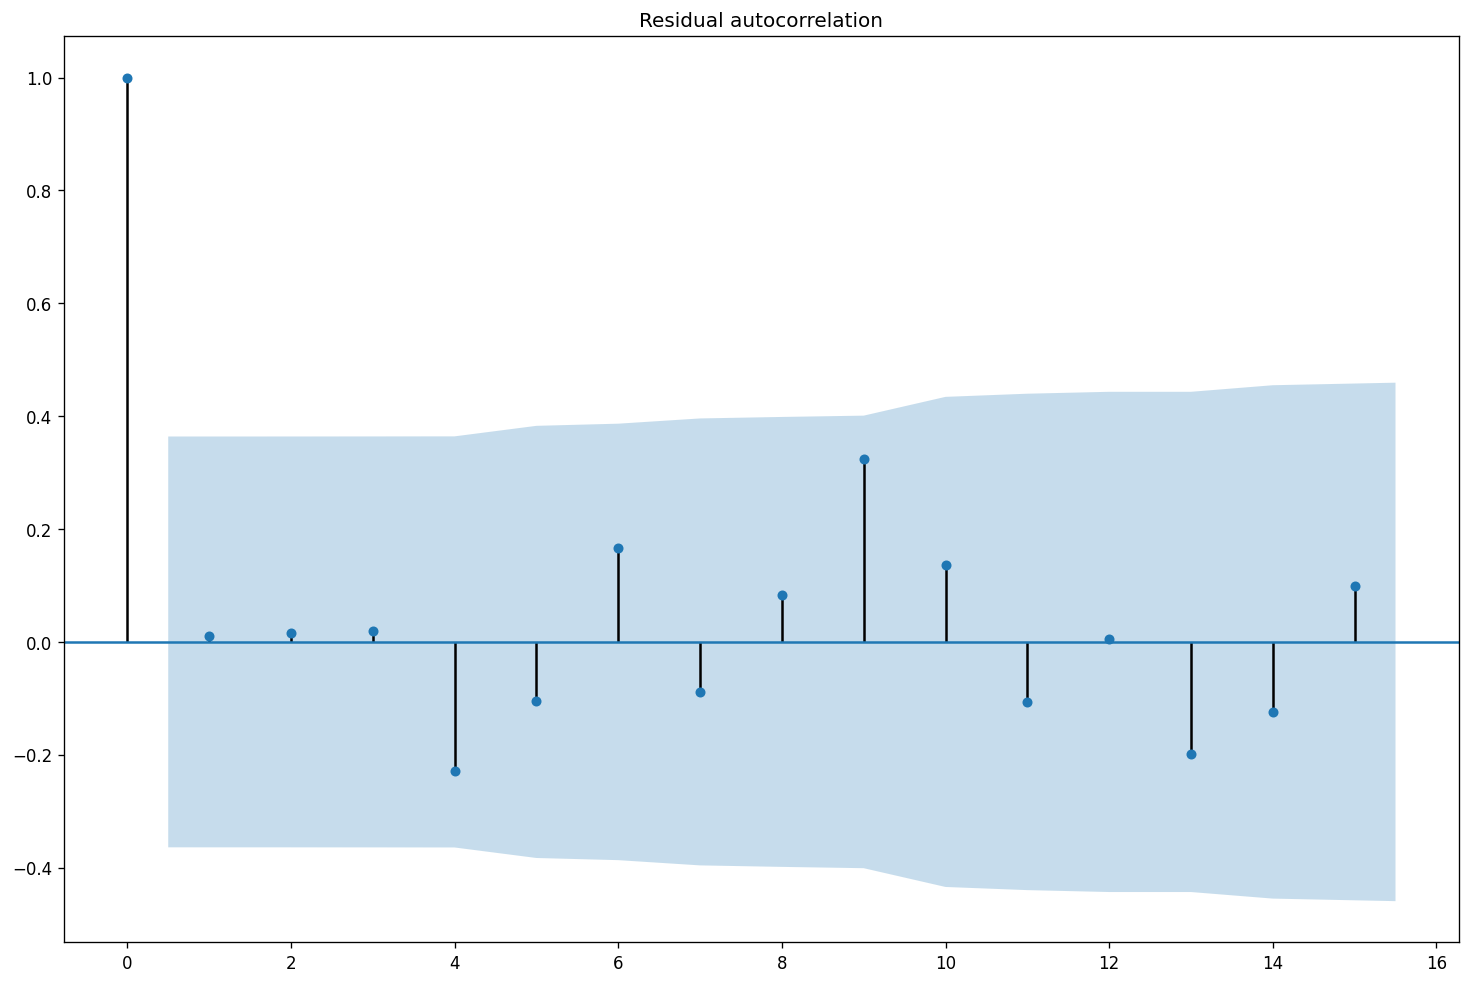

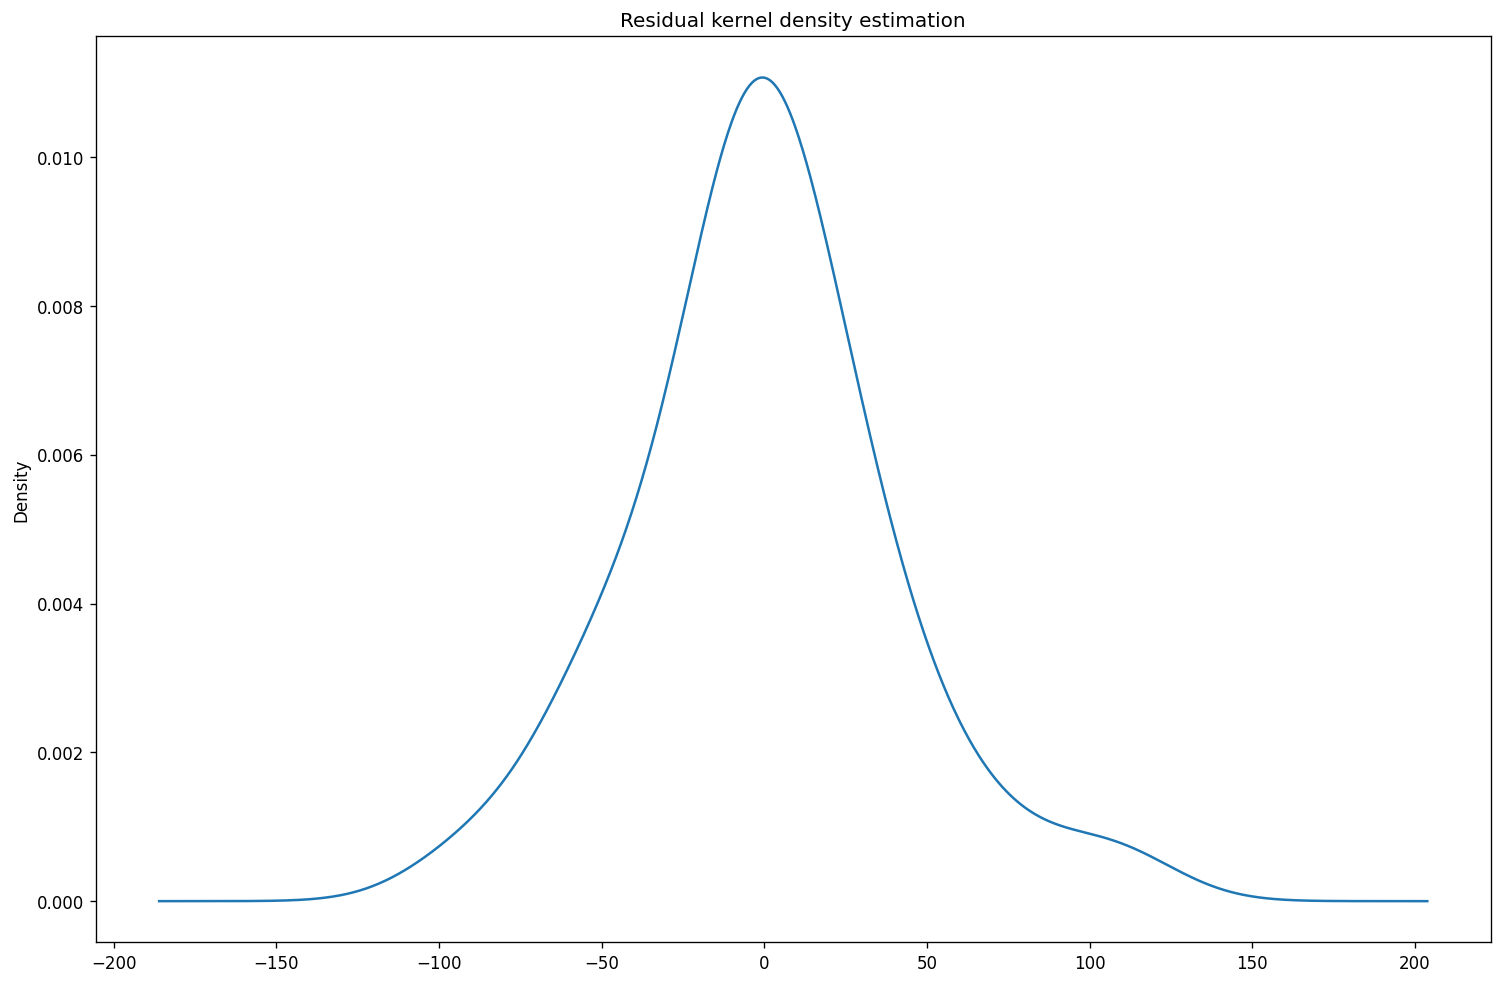

                0
count   29.000000
mean    -0.180785
std     39.198809
min    -88.600927
25%    -17.591851
50%     -1.414387
75%     21.172518
max    106.363098
p value is  0.22330982294486232
null hypothesis: residuals comes from a normal distribution
The null hypothesis cannot be rejected


In [36]:
P=1
D=1
Q=1

# fit model
N=30
series = frdf['food_retailing']   
model = ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit(disp = 0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
# plt.figure(figsize = (6,4))
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals comes from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [37]:
model_fit.aic

302.225559840795

Forecast

In [41]:
df['year'] = pd.to_datetime(df['month']).dt.year
df = df.groupby('year').sum()

In [43]:
category = 'food_retailing'
series=df[category]

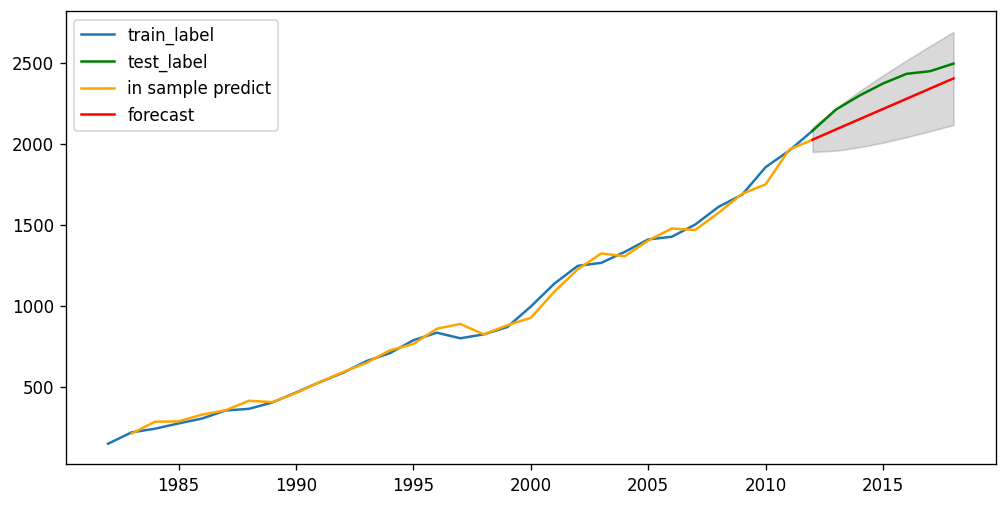

In [44]:
forecast = model_fit.forecast(steps=len(series)-N, alpha=0.05)[0]  # 95% conf
# Forecast
fc, se, conf = model_fit.forecast(steps=len(series)-N, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=range(N,len(series)))
lower_series = pd.Series(conf[:, 0], index=range(N,len(series)))
upper_series = pd.Series(conf[:, 1], index=range(N,len(series)))

plt.rcParams.update({'figure.figsize':(10,5)})
# plt.plot(series)

# plt.plot(series)
plt.plot(df.index[:N+1],series[:N+1],label='train_label')
plt.plot(df.index[N:],series[N:],color='green',label='test_label')
plt.plot(df.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),color='orange',label='in sample predict')
plt.plot(df.iloc[N:].index,fc_series.tolist(), label='forecast', color='red')
plt.fill_between(df.iloc[N:].index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left')

***Using ARIMA model to predict a one-direction random walk.***

Task 1, generate a one-dimensional random walk which starts at 0 and makes a step up or down with the equal probability. Simulate 1000 steps and use the random seed 1234. Visualize the result.

In [45]:
np.random.seed(1234)
nsteps = 1000

pos1 = 0 
walk1 = [pos1]
for i in range(nsteps):
    step1 = 1 if np.random.randint(0, 2) else -1 
    pos1 += step1
    walk1.append(pos1)

Text(0.5, 1.0, 'Random Walk')

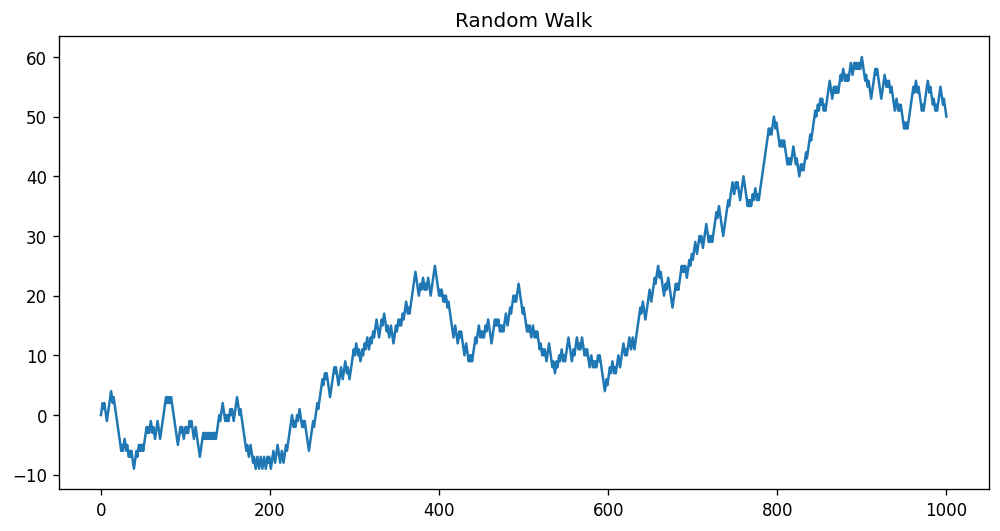

In [46]:
plt.plot(walk1)
plt.title('Random Walk')

Task 2: Make the series stationary. Report results from Augmented Dickey–Fuller Test at alpha=0.05.

In [47]:
walk = pd.Series(walk1)
result = adfuller(walk.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -31.746941
p-value: 0.000000


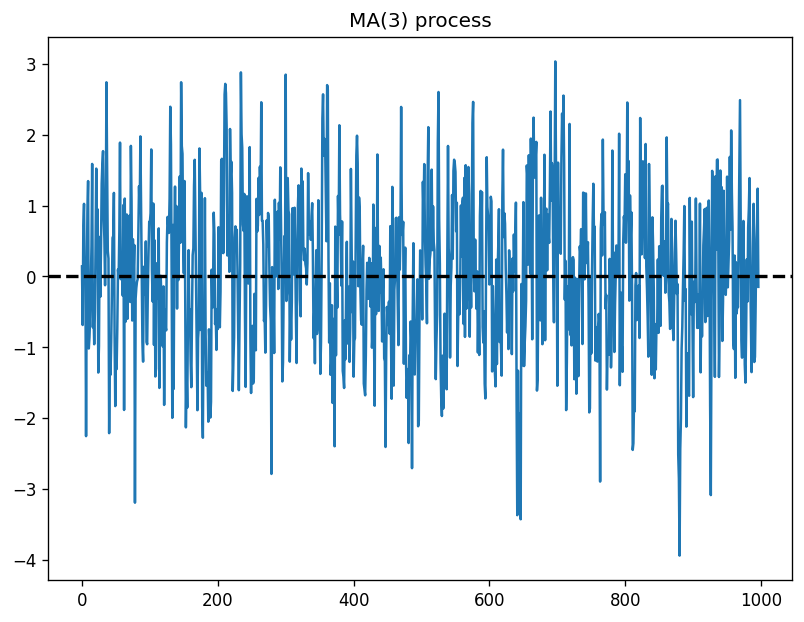

In [48]:
plt.rcParams.update({'figure.figsize':(10,5)})
T = 1000
p = 3
#generating and visualizing MA(3) process
theta=[1, 0.5, 0.3, 0.2]
np.random.seed(1234)
y=np.random.normal(0, 1, T)
x=0
for k in range(0,p+1):
    x=x+theta[k]*y[range(p-k,T-k)]
plt.figure(figsize = (8, 6))
plt.plot(x)
#plt.ylim(-4, 4)
plt.title('MA(3) process')
plt.axhline(0, color='k', ls='--', lw=2)

In [49]:
result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.620009
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


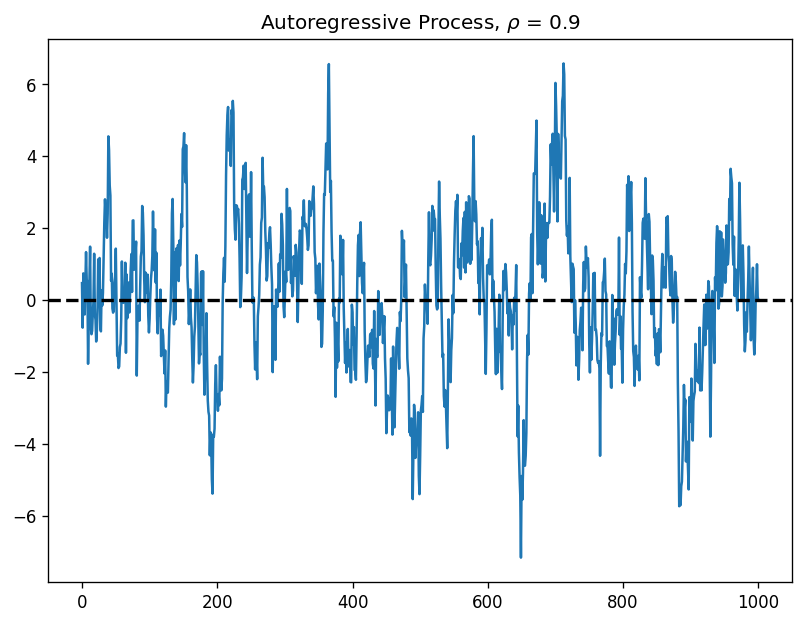

In [50]:
np.random.seed(1234)
#generating and visualizing AR(1) process
T = 1000
rho = 0.9
x = np.zeros(T+1)

x[0] = np.random.normal(0, 1)

for t in range(1, T):
    x[t] = rho * x[t-1] + np.random.normal(0, 1)

r = rho
plt.figure(figsize = (8, 6))
plt.plot(x)
#plt.ylim(-4, 4)
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r))
plt.axhline(0, color='k', ls='--', lw=2)

In [51]:
result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.094081
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


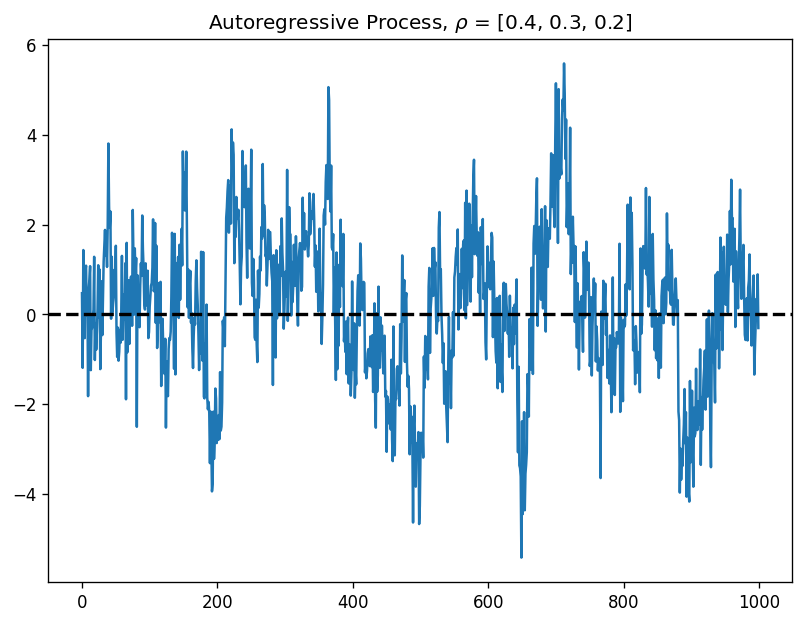

In [53]:
np.random.seed(1234)
#generating and visualizing AR(3) process
T = 1000
rho = [0.4, 0.3, 0.2]
x = np.zeros(T+1)

x = np.random.normal(0, 1, 3)

for t in range(3, T):
    x=np.append( x, rho [0] * x[t-1] + rho [1] * x[t-2] + rho [2] * x[t-3] + np.random.normal(0, 1))

r = rho
plt.figure(figsize = (8, 6))
plt.plot(x)
#plt.ylim(-4, 4)
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r))
plt.axhline(0, color='k', ls='--', lw=2)
plt.show()

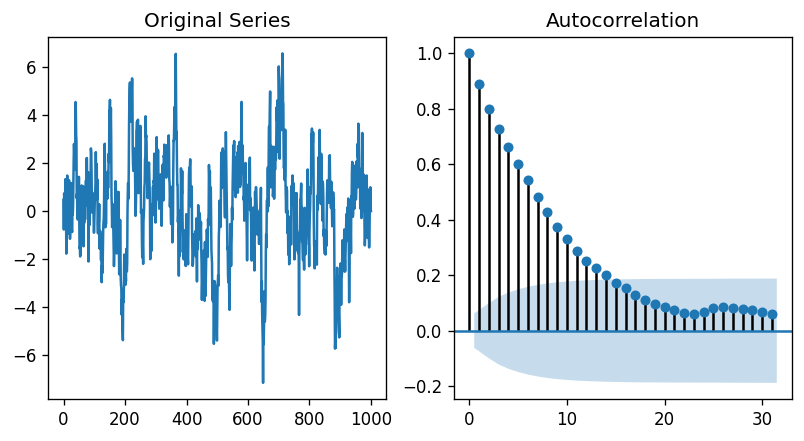

ADF Statistic: -7.094081
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [52]:
fig, axes = plt.subplots(1, 2,figsize=(8,4))
axes[0].plot(x)
axes[0].set_title('Original Series')
plot_acf(x, ax=axes[1])
plt.show()

result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [54]:
from numpy.random import normal
from numpy import *
def ARMAgenerator(phi,theta,sigma,n,burnin=0,verbose=0):
    l=max(len(phi),len(theta))
    if(burnin==0):
        burnin=10*l # Burn-in elements!
    w=normal(0,sigma,n+burnin)
    ARMA=array([])
    s=0.0
    l=max(len(phi),len(theta))
    for i in range(n+burnin):
        if(i<l):
            ARMA=append(ARMA,w[i])
        else:
            s=0.0
            for j in range(len(phi)):
                s=s+phi[j]*ARMA[i-j-1]
            for j in range(len(theta)):
                s=s+theta[j]*w[i-j-1]
        ARMA=append(ARMA,s+w[i])
    if(verbose!=0):
        print ('Measured standard deviation: '+str(sqrt(var(w[burnin:]))))
    return ARMA[burnin:]

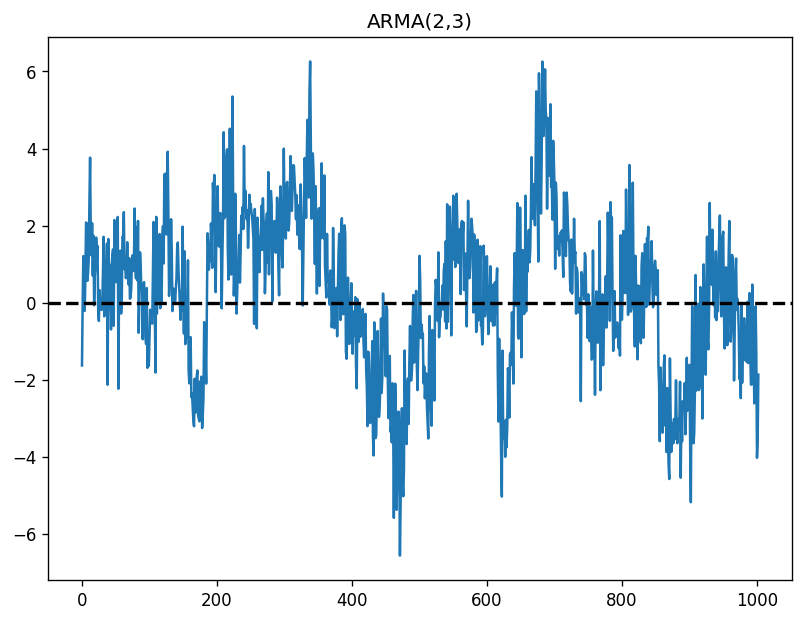

In [55]:
random.seed(1234)
x=ARMAgenerator([0.5, 0.4],[0.4,0.3,0.2],1,1000)
plt.figure(figsize = (8, 6))
plt.plot(x)
plt.title(r'ARMA(2,3)')
plt.axhline(0, color='k', ls='--', lw=2)

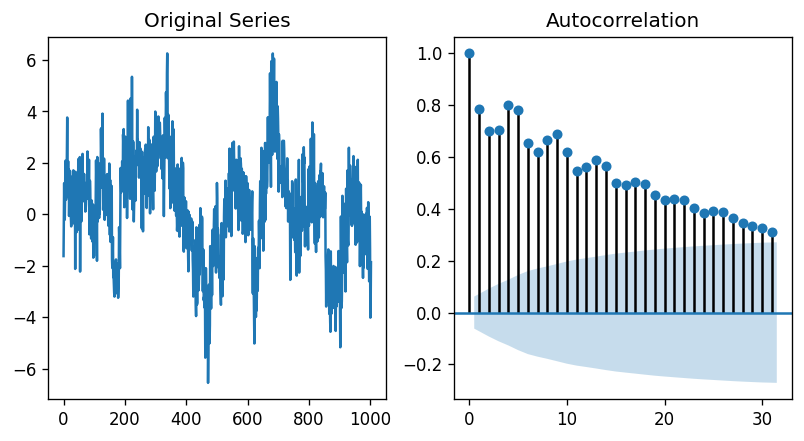

ADF Statistic: -3.604239
p-value: 0.005680
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [56]:
fig, axes = plt.subplots(1, 2,figsize=(8,4))
axes[0].plot(x)
axes[0].set_title('Original Series')
plot_acf(x, ax=axes[1])
plt.show()

result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

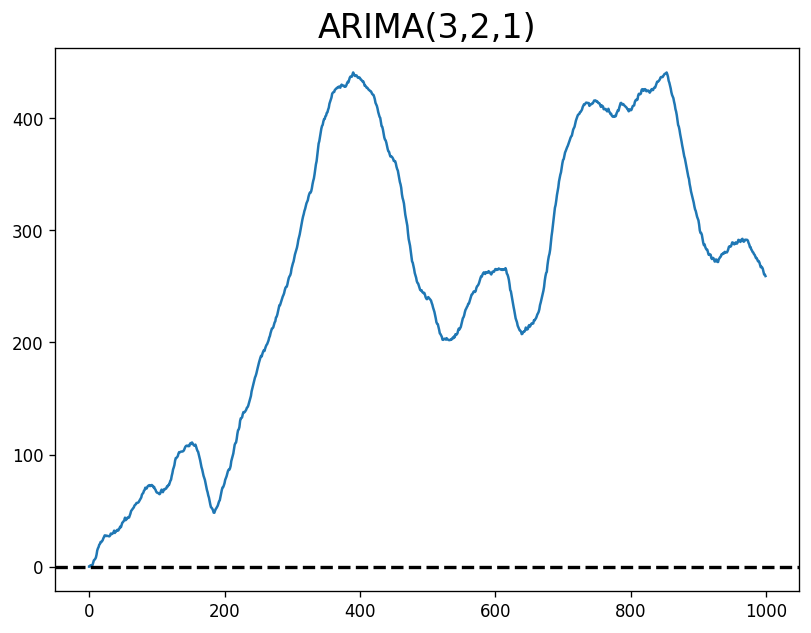

In [57]:
T = 1000
x1=[0]
for t in range(1, T):
    x1=np.append( x1, x1[t-1] + x[t])

plt.figure(figsize = (8, 6))
plt.plot(x1)
plt.title(r'ARIMA(3,2,1)', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)
plt.show();

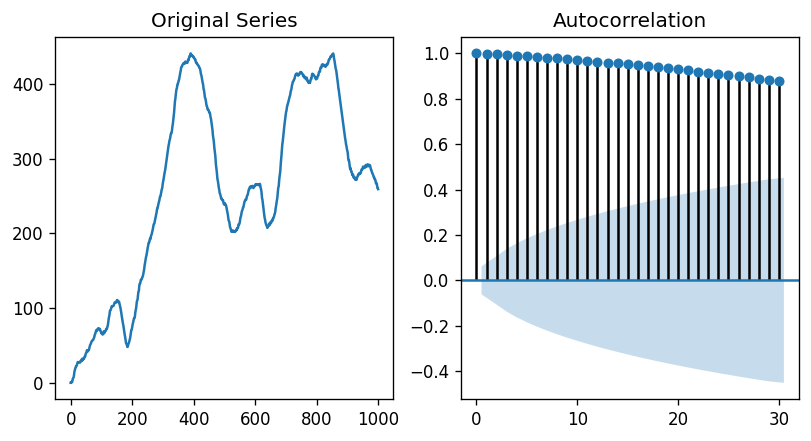

ADF Statistic: -2.222875
p-value: 0.198048
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [58]:
fig, axes = plt.subplots(1, 2,figsize=(8,4))
axes[0].plot(x1)
axes[0].set_title('Original Series')
plot_acf(x1, ax=axes[1])
plt.show()

result = adfuller(x1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Task 3: Difference the series and plot their PACF and ACFs. What do you notice?

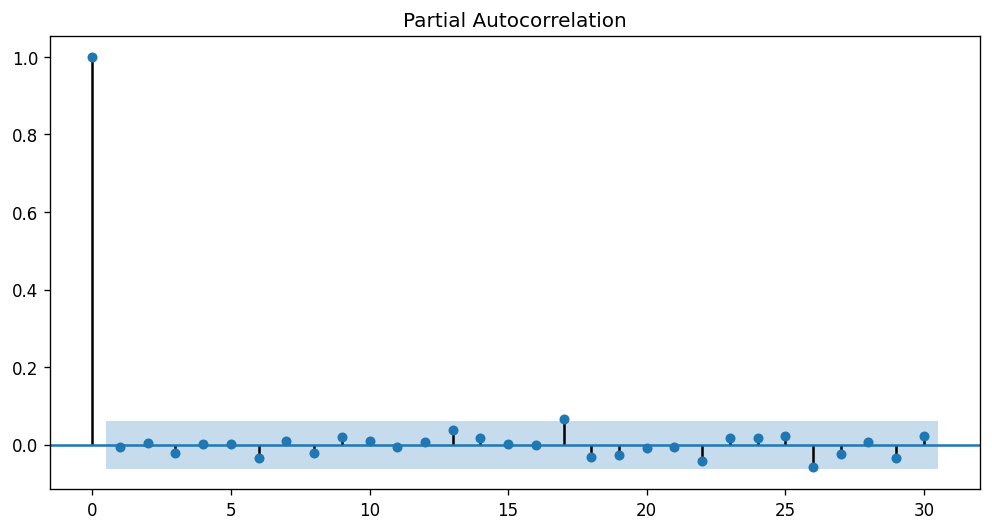

In [61]:
fig = plot_pacf(walk.diff().dropna())

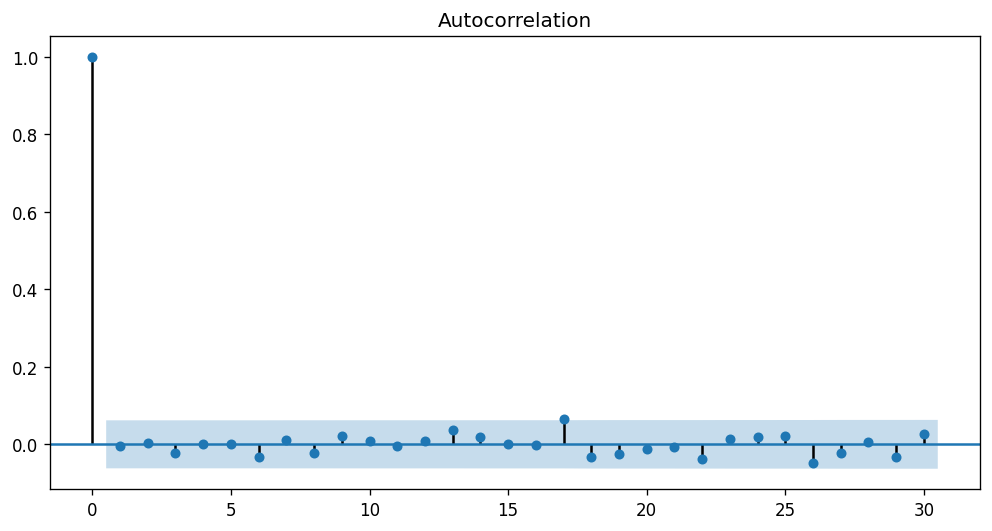

In [62]:
fig = plot_acf(walk.diff().dropna())

In [59]:
np.random.seed(1234)
#generating and visualizing AR(3) process
T = 1000
rho = [0.4, 0.3, 0.2]
x = np.zeros(T+1)

x = np.random.normal(0, 1, 3)

for t in range(3, T):
    x=np.append( x, rho [0] * x[t-1] + rho [1] * x[t-2] + rho [2] * x[t-3] + np.random.normal(0, 1))

result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.390887
p-value: 0.000004
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


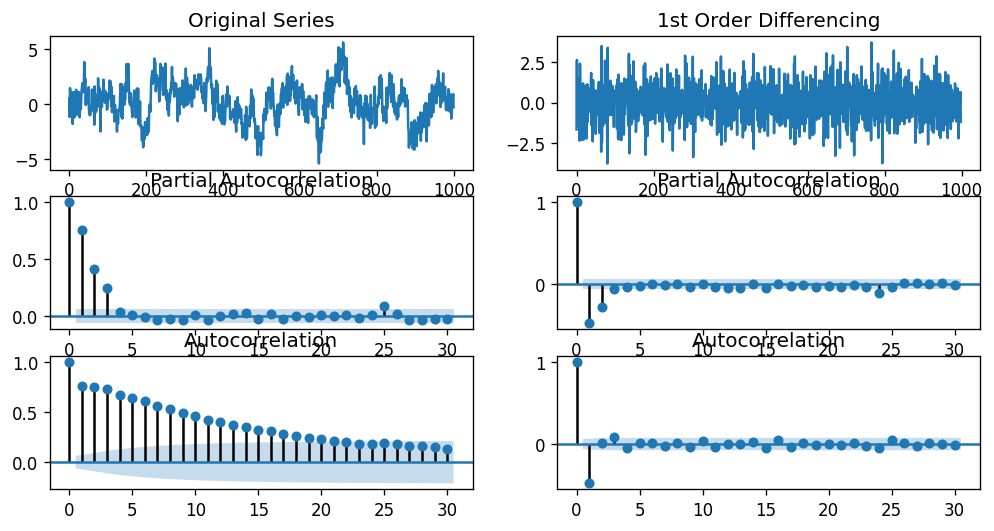

In [60]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(x); axes[0, 0].set_title('Original Series')
axes[0, 1].plot(np.diff(x)); axes[0, 1].set_title('1st Order Differencing')

#PACF
plot_pacf(x, ax=axes[1, 0])
#axes[1, 0].set_title('Partial Autocorrelation')
plot_pacf(np.diff(x), ax=axes[1, 1])
#axes[1, 1].set_title('Partial Autocorrelation')

#ACF
plot_acf(x, ax=axes[2, 0])
#axes[2, 0].set_title('Autocorrelation')
plot_acf(np.diff(x), ax=axes[2, 1])
#axes[2, 1].set_title('Autocorrelation')

plt.show()

Task 4: When analyzing the PACF and ACF results of the random walk, what pattern shows that ARIMA won't be a useful model for this time-series?

> In the PACF and ACF plots, we can hardly find any significant correlations (values outside of the blue area) over any lag values. As its name indicates, this situation makes sense, a random walk is random. Even though the current position is based on the previous position, a single differencing removes this relationship. So after differencing, ARIMA (or actually ARMA) will be challenged to modeling the differences between consequitive steps, which are randomly generated and according to the ACF/PACF plots do not show any significant autocorrelations. ARIMA can not help modeling a dataset if autocorrelation does not exist in it.